In [1]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns

## Fatty Acid Synthesis Model

### Model Specification

In [2]:
###Color palette
orders = ['Open Loop', 'Open Loop Intermediate', 'Negative Gene Loop', 'Negative Metabolic Loop', 'Layered Negative Metabolic Loop']
palette = {'Open Loop': sns.color_palette()[3], 'Open Loop Intermediate': 'tab:purple', 'Negative Metabolic Loop': 'tab:green', 'Negative Gene Loop': 'tab:orange', 'Layered Negative Metabolic Loop': 'tab:blue', 'Initial':'black'}

###Helper functions
def michaelismenten(x, vm, km):
    return (vm*x)/(km+x)

def promoteractivation(x, r, kd):
    return r/(1+(x/kd))

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

###Model definition
def fa_openloop(t, y, ydot, params):
    FFA, tesA, j1, j2 = y
    mu = 3.85E-4
    k_tesA = 100.
    r_lac = params
    ydot[0] = tesA*k_tesA - mu*FFA
    ydot[1] = r_lac - mu*tesA
    ydot[2] = tesA*k_tesA 
    ydot[3] = r_lac

def fa_openloopintermediate(t, y, ydot, params):
    FFA, tesA, CAR, j1, j2 = y
    mu = 3.85E-4
    k_car = 2.83E-4
    k_tesA = 100
    r_lac, r_bad = params
    ydot[0] = tesA * k_tesA - mu * FFA - CAR * k_car
    ydot[1] = r_lac - mu*tesA
    ydot[2] = r_bad - mu*CAR
    ydot[3] = tesA * k_tesA - CAR * k_car
    ydot[4] = r_bad + r_lac

def fa_negativegeneloop(t, y, ydot, params):
    FFA, tesA, tetR, j1, j2 = y
    mu = 3.85E-4
    kd_tetR = 3.0E-8
    k_tesA = 105.25
    r_tl, r_tl_tetR = params
    ydot[0] = tesA * k_tesA - mu * FFA
    ydot[1] = promoteractivation(tetR, r_tl, kd_tetR) - mu * tesA
    ydot[2] = promoteractivation(tetR, r_tl_tetR, kd_tetR) - mu * tetR
    ydot[3] = tesA * k_tesA
    ydot[4] = promoteractivation(tetR, r_tl, kd_tetR) + promoteractivation(tetR, r_tl_tetR, kd_tetR)

def fa_negativemetabolicloop(t, y, ydot, params):
    FFA, tesA, j1, j2 = y
    k_tesA = 77.75
    mu = 3.85E-4
    r_fl_prime, ki = params
    ydot[0] = k_tesA * tesA - mu*FFA
    ydot[1] = promoteractivation(FFA, r_fl_prime, ki) - mu * tesA
    ydot[2] = k_tesA * tesA
    ydot[3] = promoteractivation(FFA, r_fl_prime, ki) 

def fa_layerednegativemetabolicloop(t, y, ydot, params):
    FFA,  tesA , tetR, j1, j2 = y
    k_tesA = 230.9
    kd_tetR = 3.85E-8
    kd_fadR_FFA = 0.001
    k2 = 138.50
    mu = 3.85E-4
    r_tl, r_ar2 = params
    ydot[0] = tesA * k_tesA - mu * FFA
    ydot[1] = promoteractivation(tetR, r_tl, kd_tetR) - mu*tesA
    ydot[2] = promoteractivation(k2, r_ar2, (1+(FFA/kd_fadR_FFA))) - mu*tetR
    ydot[3] = tesA * k_tesA
    ydot[4] = promoteractivation(tetR, r_tl, kd_tetR) + promoteractivation(k2, r_ar2, (1+(FFA/kd_fadR_FFA)))

###Search space definition
space = hp.choice('architecture',
    [('Open Loop', hp.uniform('r_lac_ol', 10E-11, 10E-8)),
        ('Open Loop Intermediate', [hp.uniform('r_lac_oli', 10E-11, 10E-8), hp.uniform('r_bad_oli', 10E-11, 10E-8)]),
        ('Negative Gene Loop', [hp.uniform('r_tl_ngl', 10E-11, 10E-8),hp.uniform('r_tl_tetR_ngl', 10E-11, 10E-8)]),
        ('Negative Metabolic Loop', [hp.uniform('r_fl_prime_nml', 10E-11, 10E-8), hp.uniform('ki_nml', 0., 0.12)]),
        ('Layered Negative Metabolic Loop', [hp.uniform('r_tl_lnml', 10E-11, 10E-8), hp.uniform('r_ar2_lnml', 10E-11, 10E-8),])
        ])

###Objective function
def run_opt(max_iters):
    losses = []
    params = []
    circuits = []

    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E4, 200)

        #Select architecture and generate function
        if architecture == 'Open Loop':
            ode_function = fa_openloop
            y0 = np.array([0., 0., 0., 0.])
        elif architecture == 'Open Loop Intermediate':
            ode_function = fa_openloopintermediate
            y0 = np.array([0., 0., 0., 0., 0.])
        elif architecture == 'Negative Gene Loop':
            ode_function = fa_negativegeneloop
            y0 = np.array([0., 0., 0., 0., 0.])
        elif architecture == 'Negative Metabolic Loop':
            ode_function = fa_negativemetabolicloop
            y0 = np.array([0., 0., 0., 0.])
        else:
            ode_function = fa_layerednegativemetabolicloop
            y0 = np.array([0., 0., 0., 0., 0.])
        
        extra_options = {'old_api': False, 'user_data': param_values}
        ode_solver = ode('cvode', ode_function, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1 = solution.values.y[-1][-1]
        j2 = solution.values.y[-1][-2]
        j1, j2, loss = loss_biological(j1, j2, alpha1=10E3, alpha2=10E-2)

        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    
    #Create trajectory data frame
    r_lac_ols, r_lac_olis, r_bad_olis, r_tl_ngls, r_tl_tetR_ngls, r_fl_prime_nmls, ki_nmls, r_tl_lnmls, r_ar2_lnmls = [[], [], [], [], [], [], [], [], []]
    for i in range(max_iters):
        r_lac_ol, r_lac_oli, r_bad_oli, r_tl_ngl, r_tl_tetR_ngl, r_fl_prime_nml, ki_nml, r_tl_lnml, r_ar2_lnml = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        arch = circuits[i]
        if arch == 'Open Loop':
            r_lac_ol = params[i]
        elif arch == 'Open Loop Intermediate':
            r_lac_oli  = params[i][0]
            r_bad_oli = params[i][1]
        elif arch == 'Negative Gene Loop':
            r_tl_ngl = params[i][0]
            r_tl_tetR_ngl = params[i][1]
        elif arch == 'Negative Metabolic Loop':
            r_fl_prime_nml = params[i][0]
            ki_nml = params[i][1]
        else:
            r_tl_lnml = params[i][0]
            r_ar2_lnml = params[i][1]
        
        r_lac_ols.append(r_lac_ol)
        r_lac_olis.append(r_lac_oli)
        r_bad_olis.append(r_bad_oli)
        r_tl_ngls.append(r_tl_ngl)
        r_tl_tetR_ngls.append(r_tl_tetR_ngl)
        r_fl_prime_nmls.append(r_fl_prime_nml)
        ki_nmls.append(ki_nml)
        r_tl_lnmls.append(r_tl_lnml)
        r_ar2_lnmls.append(r_ar2_lnml)
        
    landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'r_lac_ol':r_lac_ols, 'r_lac_oli':r_lac_olis, 'r_bad_oli':r_bad_olis,
            'r_tl_ngl':r_tl_ngls, 'r_tl_tetR_ngl':r_tl_tetR_ngls, 'r_fl_prime_nml':r_fl_prime_nmls,
            'ki_nml':ki_nmls, 'r_tl_lnml':r_tl_lnmls, 'r_ar2_lnml':r_ar2_lnmls})    

    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss:
            best_loss = landscape.loss[i]
            best_circuit = landscape.circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits
    
    return landscape, best

### Simulation Experiments

In [21]:
###Run sample optimization
max_iters = 1000
landscape, best = run_opt(max_iters)
landscape = landscape.reset_index()
landscape.to_csv('sample_run.csv')

100%|██████████| 1000/1000 [00:13<00:00, 72.20trial/s, best loss: 0.005278741573166356]


In [246]:
###Run N=100 times and compute parameter robustness - takes about 30 min
num_replicates = 100
max_iters = 500

space = hp.choice('architecture',
    [('Open Loop', hp.uniform('r_lac_ol', 10E-11, 10E-8))])
ol_landscape = pd.DataFrame()
for i in range(num_replicates):
    landscape, best = run_opt(max_iters)
    landscape = landscape.reset_index()
    landscape['iteration'] = landscape['index']
    landscape['replicate'] = i+1
    ol_landscape = pd.concat([ol_landscape, landscape])

space = hp.choice('architecture',
    [('Open Loop Intermediate', [hp.uniform('r_lac_oli', 10E-11, 10E-8), hp.uniform('r_bad_oli', 10E-11, 10E-8)])])
oli_landscape = pd.DataFrame()
for i in range(num_replicates):
    landscape, best = run_opt(max_iters)
    landscape = landscape.reset_index()
    landscape['iteration'] = landscape['index']
    landscape['replicate'] = i+1
    oli_landscape = pd.concat([oli_landscape, landscape])

space = hp.choice('architecture',
    [('Negative Gene Loop', [hp.uniform('r_tl_ngl', 10E-11, 10E-8),hp.uniform('r_tl_tetR_ngl', 10E-11, 10E-8)])])
ngl_landscape = pd.DataFrame()
for i in range(num_replicates):
    landscape, best = run_opt(max_iters)
    landscape = landscape.reset_index()
    landscape['iteration'] = landscape['index']
    landscape['replicate'] = i+1
    ngl_landscape = pd.concat([ngl_landscape, landscape])

space = hp.choice('architecture',
    [('Negative Metabolic Loop', [hp.uniform('r_fl_prime_nml', 10E-11, 10E-8), hp.uniform('ki_nml', 0., 0.12)])])
nml_landscape = pd.DataFrame()
for i in range(num_replicates):
    landscape, best = run_opt(max_iters)
    landscape = landscape.reset_index()
    landscape['iteration'] = landscape['index']
    landscape['replicate'] = i+1
    nml_landscape = pd.concat([nml_landscape, landscape])

space = hp.choice('architecture',
    [('Layered Negative Metabolic Loop', [hp.uniform('r_tl_lnml', 10E-11, 10E-8), hp.uniform('r_ar2_lnml', 10E-11, 10E-8),])])
lnml_landscape = pd.DataFrame()
for i in range(num_replicates):
    landscape, best = run_opt(max_iters)
    landscape = landscape.reset_index()
    landscape['iteration'] = landscape['index']
    landscape['replicate'] = i+1
    lnml_landscape = pd.concat([lnml_landscape, landscape])

total_landscape = pd.concat([ol_landscape, oli_landscape, ngl_landscape, nml_landscape, lnml_landscape])
total_landscape.to_csv('background.csv')

 73%|███████▎  | 365/500 [00:01<00:00, 241.35trial/s, best loss: 0.17386386702862416]


KeyboardInterrupt: 

### Visualization

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


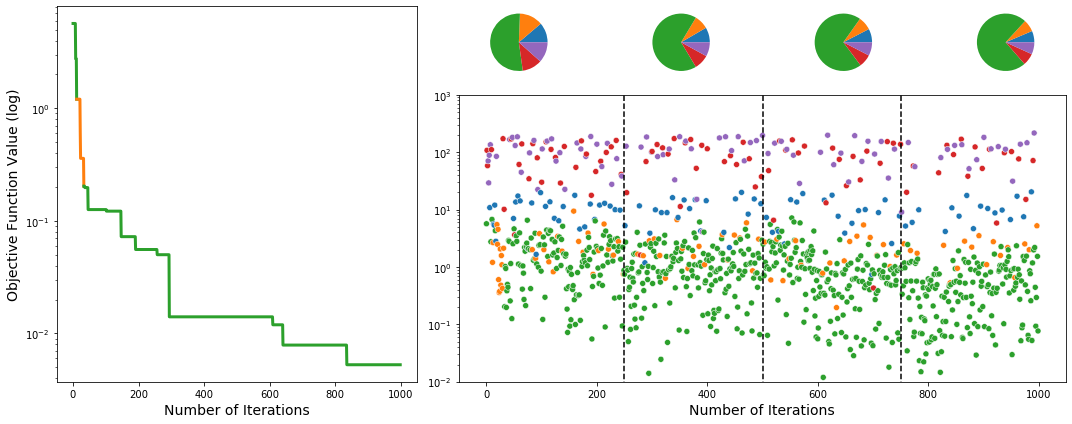

In [250]:
###FIGURE: Sample results
landscape = pd.read_csv('sample_run.csv')
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(nrows=2, ncols=5, height_ratios=[1,4 ], width_ratios=[3, 1, 1, 1, 1])

ax = fig.add_subplot(gs[:, 0])
prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color=palette[a], linewidth=3)
ax.set_ylabel('Objective Function Value (log)', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)

ax = fig.add_subplot(gs[1, 1:])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([10E-3, 10E2])
sns.scatterplot(x='index', y='loss', hue='circuit', data=landscape, ax=ax, palette=palette, hue_order=orders, legend=False)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')
ax.set_ylabel(None)


quarter1 = (landscape.iloc[0:250].sort_values(by='circuit').groupby('circuit').count().loss/200).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='circuit').groupby('circuit').count().loss/200).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='circuit').groupby('circuit').count().loss/200).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='circuit').groupby('circuit').count().loss/200).reset_index()
colors = ['tab:blue', 'tab:orange', 'tab:green', sns.color_palette()[3], 'tab:purple']

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter1.loss, colors=colors)

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter2.loss, colors=colors)

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter3.loss, colors=colors)

ax = fig.add_subplot(gs[0, 4])
ax.pie(quarter4.loss, colors=colors)

fig.tight_layout()
fig.savefig('sample_results.png', dpi=300)


#### Parameter sloppiness

In [3]:
total_landscape = pd.read_csv('parameter_sloppiness.csv')
plot_landscape = total_landscape.loc[total_landscape.iteration == 499]

ol_landscape = total_landscape.loc[total_landscape.circuit == 'Open Loop'].reset_index(drop=True)
oli_landscape = total_landscape.loc[total_landscape.circuit == 'Open Loop Intermediate'].reset_index(drop=True)
ngl_landscape = total_landscape.loc[total_landscape.circuit == 'Negative Gene Loop'].reset_index(drop=True)
nml_landscape = total_landscape.loc[total_landscape.circuit == 'Negative Metabolic Loop'].reset_index(drop=True)
lnml_landscape = total_landscape.loc[total_landscape.circuit == 'Layered Negative Metabolic Loop'].reset_index(drop=True)

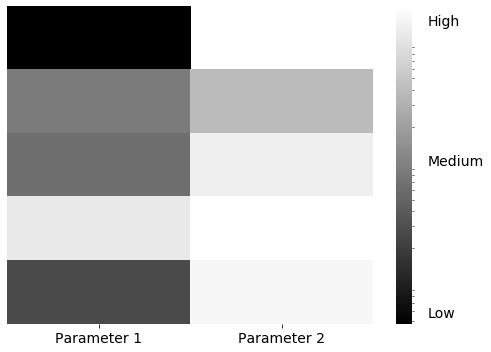

In [16]:
###FIGURE: Parameter sloppiness
pr_r_lac_ol = ol_landscape.loc[ol_landscape.loss.isin(ol_landscape.loc[ol_landscape.iteration == 100].best_losses.to_list())].r_lac_ol.std()/(10E-8 - 10E-11)
pr_r_lac_oli = oli_landscape.loc[oli_landscape.loss.isin(oli_landscape.loc[oli_landscape.iteration == 100].best_losses.to_list())].r_lac_oli.std()/(10E-8 - 10E-11)
pr_r_bad_oli = oli_landscape.loc[oli_landscape.loss.isin(oli_landscape.loc[oli_landscape.iteration == 100].best_losses.to_list())].r_bad_oli.std()/(10E-8 - 10E-11)
pr_r_tl_ngl = ngl_landscape.loc[ngl_landscape.loss.isin(ngl_landscape.loc[ngl_landscape.iteration == 100].best_losses.to_list())].r_tl_ngl.std()/(10E-8 - 10E-11)
pr_r_tl_tetR_ngl = ngl_landscape.loc[ngl_landscape.loss.isin(ngl_landscape.loc[ngl_landscape.iteration == 100].best_losses.to_list())].r_tl_tetR_ngl.std()/(10E-8 - 10E-11)
pr_r_fl_prime_nml = nml_landscape.loc[nml_landscape.loss.isin(nml_landscape.loc[nml_landscape.iteration == 100].best_losses.to_list())].r_fl_prime_nml.std()/(10E-8 - 10E-11)
pr_ki_nml = nml_landscape.loc[nml_landscape.loss.isin(nml_landscape.loc[nml_landscape.iteration == 100].best_losses.to_list())].ki_nml.std()/(0.12)
pr_r_tl_lnml = lnml_landscape.loc[lnml_landscape.loss.isin(lnml_landscape.loc[lnml_landscape.iteration == 100].best_losses.to_list())].r_tl_lnml.std()/(10E-8 - 10E-11)
pr_r_ar2_lnml = lnml_landscape.loc[lnml_landscape.loss.isin(lnml_landscape.loc[lnml_landscape.iteration == 100].best_losses.to_list())].r_ar2_lnml.std()/(10E-8 - 10E-11)

test = pd.DataFrame({'Architecture': orders, 'Parameter 1': [pr_r_lac_ol, pr_r_lac_oli, pr_r_tl_ngl, pr_r_fl_prime_nml, pr_r_tl_lnml], 'Parameter 2': [None, pr_r_bad_oli, pr_r_tl_tetR_ngl, pr_ki_nml, pr_r_ar2_lnml]}).set_index('Architecture')

fig, ax = plt.subplots(1,1,figsize=(7, 5))
sns.heatmap(test, cmap="gray", norm=LogNorm(), ax=ax, cbar_kws={"ticks":[-1, 0, 1], 'orientation':'vertical'})
ax.set_ylabel(None)
ax.set_yticklabels('')
ax.set_yticks([])
ax.set_xticklabels(['Parameter 1', 'Parameter 2'], fontsize=14)
ax.text(2.3, 0.3, 'High', fontsize=14)
ax.text(2.3, 2.5, 'Medium', fontsize=14)
ax.text(2.3, 4.9, 'Low', fontsize=14)
fig.tight_layout()
fig.savefig('parameter_sloppiness.png', dpi=300)


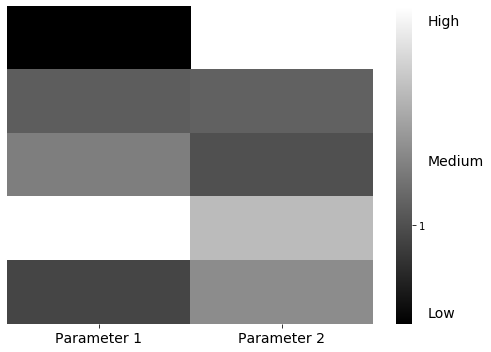

In [30]:
###FIGURE: Parameter sloppiness with coefficient of variation
ol = ol_landscape.loc[ol_landscape.loss.isin(ol_landscape.loc[ol_landscape.iteration == 100].best_losses.to_list())]
oli = oli_landscape.loc[oli_landscape.loss.isin(oli_landscape.loc[oli_landscape.iteration == 100].best_losses.to_list())]
ngl = ngl_landscape.loc[ngl_landscape.loss.isin(ngl_landscape.loc[ngl_landscape.iteration == 100].best_losses.to_list())]
nml = nml_landscape.loc[nml_landscape.loss.isin(nml_landscape.loc[nml_landscape.iteration == 100].best_losses.to_list())]
lnml = lnml_landscape.loc[lnml_landscape.loss.isin(lnml_landscape.loc[lnml_landscape.iteration == 100].best_losses.to_list())]
pr_r_lac_ol = ol.r_lac_ol.std()/ol.r_lac_ol.mean()
pr_r_lac_oli = oli.r_lac_oli.std()/oli.r_lac_oli.mean()
pr_r_bad_oli = oli.r_bad_oli.std()/oli.r_bad_oli.mean()
pr_r_tl_ngl = ngl.r_tl_ngl.std()/ngl.r_tl_ngl.mean()
pr_r_tl_tetR_ngl = ngl.r_tl_tetR_ngl.std()/ngl.r_tl_tetR_ngl.mean()
pr_r_fl_prime_nml = nml.r_fl_prime_nml.std()/nml.r_fl_prime_nml.mean()
pr_ki_nml = nml.ki_nml.std()/nml.ki_nml.mean()
pr_r_tl_lnml = lnml.r_tl_lnml.std()/lnml.r_tl_lnml.mean()
pr_r_ar2_lnml = lnml.r_ar2_lnml.std()/lnml.r_ar2_lnml.mean()

test = pd.DataFrame({'Architecture': orders, 'Parameter 1': [pr_r_lac_ol, pr_r_lac_oli, pr_r_tl_ngl, pr_r_fl_prime_nml, pr_r_tl_lnml], 'Parameter 2': [None, pr_r_bad_oli, pr_r_tl_tetR_ngl, pr_ki_nml, pr_r_ar2_lnml]}).set_index('Architecture')

fig, ax = plt.subplots(1,1,figsize=(7, 5))
sns.heatmap(test, cmap="gray", ax=ax, cbar_kws={"ticks":[-1, 0, 1], 'orientation':'vertical'})
ax.set_ylabel(None)
ax.set_yticklabels('')
ax.set_yticks([])
ax.set_xticklabels(['Parameter 1', 'Parameter 2'], fontsize=14)
ax.text(2.3, 0.3, 'High', fontsize=14)
ax.text(2.3, 2.5, 'Medium', fontsize=14)
ax.text(2.3, 4.9, 'Low', fontsize=14)
fig.tight_layout()
fig.savefig('parameter_sloppiness.png', dpi=300)

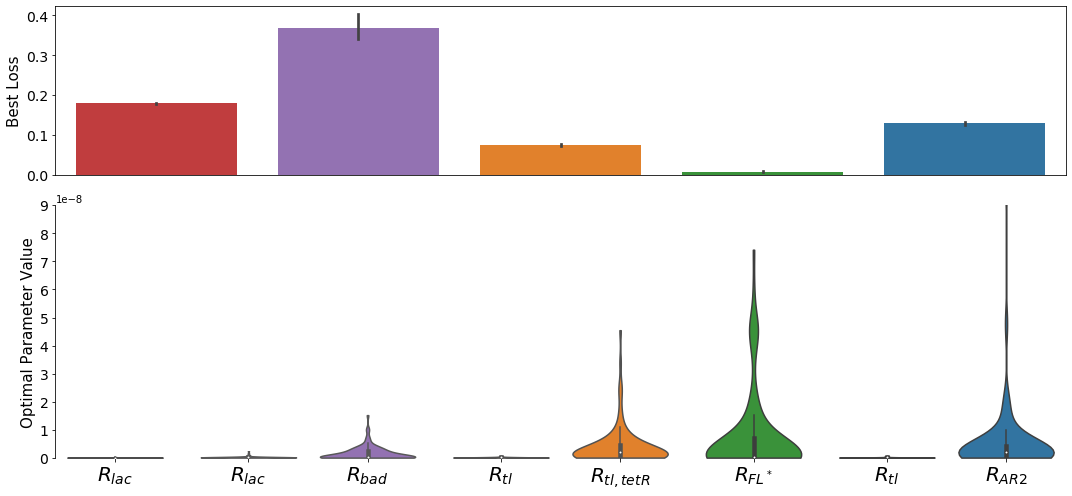

In [249]:
###FIGURE: Parameter robustness
start = 0
stop = 500
params = []
circuits = []
locs = []
for i in range(100):
    params.append(ol_landscape.iloc[start:stop].loc[ol_landscape.loss == ol_landscape.iloc[start:stop].loss.min()].r_lac_ol.to_list()[0])
    circuits.append('Open Loop')
    locs.append('$R_{lac}$')

    params.append(oli_landscape.iloc[start:stop].loc[oli_landscape.loss == oli_landscape.iloc[start:stop].loss.min()].r_lac_oli.to_list()[0])
    circuits.append('Open Loop Intermediate')
    locs.append('$R_{lac}$')

    params.append(oli_landscape.iloc[start:stop].loc[oli_landscape.loss == oli_landscape.iloc[start:stop].loss.min()].r_bad_oli.to_list()[0])
    circuits.append('Open Loop Intermediate')
    locs.append('$R_{bad}$')

    params.append(ngl_landscape.iloc[start:stop].loc[ngl_landscape.loss == ngl_landscape.iloc[start:stop].loss.min()].r_tl_ngl.to_list()[0])
    circuits.append('Negative Gene Loop')
    locs.append('$R_{tl}$')

    params.append(ngl_landscape.iloc[start:stop].loc[ngl_landscape.loss == ngl_landscape.iloc[start:stop].loss.min()].r_tl_tetR_ngl.to_list()[0])
    circuits.append('Negative Gene Loop')
    locs.append('$R_{tl, tetR}}$')

    params.append(nml_landscape.iloc[start:stop].loc[nml_landscape.loss == nml_landscape.iloc[start:stop].loss.min()].r_fl_prime_nml.to_list()[0])
    circuits.append('Negative Metabolic Loop')
    locs.append('$R_{FL^*}$')

    params.append(lnml_landscape.iloc[start:stop].loc[lnml_landscape.loss == lnml_landscape.iloc[start:stop].loss.min()].r_tl_lnml.to_list()[0])
    circuits.append('Layered Negative Metabolic Loop')
    locs.append('$R_{tl}$')

    params.append(lnml_landscape.iloc[start:stop].loc[lnml_landscape.loss == lnml_landscape.iloc[start:stop].loss.min()].r_ar2_lnml.to_list()[0])
    circuits.append('Layered Negative Metabolic Loop')
    locs.append('$R_{AR2}$')

    start=stop
    stop+= 100

plot_data = pd.DataFrame({'param':params, 'circuit':circuits, 'locs':locs})

fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(nrows=2, ncols=5, height_ratios=[1,1.5], width_ratios=[1, 2, 2, 1, 2])

ax = fig.add_subplot(gs[0, :])
sns.barplot(data=plot_landscape, y='best_losses', x='best_loss_circuit', palette=palette, hue_order=orders, ax=ax)
ax.set_ylabel('Best Loss', fontsize=15)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(None)
ax.set_xticklabels('')
ax.set_xticks([])

ax = fig.add_subplot(gs[1, 0])
sns.violinplot(data = plot_data.loc[plot_data.circuit == 'Open Loop'], y='param', x = 'locs', cut=0, color=palette['Open Loop'], edgecolor=palette['Open Loop'], scale='width', ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim([0, 9E-8])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Optimal Parameter Value', fontsize=15)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(gs[1, 1])
sns.violinplot(data = plot_data.loc[plot_data.circuit == 'Open Loop Intermediate'], y='param', x = 'locs', cut=0, color=palette['Open Loop Intermediate'], scale='width', ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim([0, 9E-8])
ax.set_yticks([])
ax.tick_params(axis='x', labelsize=20)
for spine in ax.spines.values():
        spine.set_edgecolor(None)

ax = fig.add_subplot(gs[1, 2])
sns.violinplot(data = plot_data.loc[plot_data.circuit == 'Negative Gene Loop'], y='param', x = 'locs', cut=0, color=palette['Negative Gene Loop'], scale='width', ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim([0, 9E-8])
ax.set_yticks([])
ax.tick_params(axis='x', labelsize=20)
for spine in ax.spines.values():
        spine.set_edgecolor(None)

ax = fig.add_subplot(gs[1, 3])
sns.violinplot(data = plot_data.loc[plot_data.circuit == 'Negative Metabolic Loop'], y='param', x = 'locs', cut=0, color=palette['Negative Metabolic Loop'], scale='width', ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim([0, 9E-8])
ax.set_yticks([])
ax.tick_params(axis='x', labelsize=20)
for spine in ax.spines.values():
        spine.set_edgecolor(None)

ax = fig.add_subplot(gs[1, 4])
sns.violinplot(data = plot_data.loc[plot_data.circuit == 'Layered Negative Metabolic Loop'], y='param', x = 'locs', cut=0, color=palette['Layered Negative Metabolic Loop'], edgecolor=palette['Layered Negative Metabolic Loop'], scale='width', ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim([0, 9E-8])
ax.tick_params(axis='x', labelsize=20)

ax.set_yticks([])
for spine in ax.spines.values():
        spine.set_edgecolor(None)

fig.tight_layout()
 

fig.savefig('parameter_robustness_violin.png', dpi=300)